# Voice Intonation Classification

## Introduction

In this mini project, the stated machine learning problem is to classify four types of audio intonations, given a dataset of 20K labeld short audios voicing out a number.

Building a classifier model using a labeled dataset is usually done using supervised learning techniques. We first need to understand the type of data we are dealing with, in our case, short audios, after a close examination, we should be able to identify what useful information (<font color=green>audio features</font>) which should be extracted to help us in our mission. After extracting the data, we proceed with the next step which is <font color=green>feature selection</font>. We can perform statistical analysis and data visualization to help us understand if there is a correlation between the extracted features and check if the classes are *linearly separable*, which is not always an easy task. These techniques can also help us to choose which features to use as **predictors** in our classifier, and also may reduce dimensionality if we pick less features.
Once we have the predictors prepared, we need to examine their value ranges, as sometimes we need to scale them as a <font color=green>preprocessing</font> step, this can be achieved using techniques such as normalization and standardization.

There are many models that can be used for classification, I have used <font color=green>Support Vector Machines</font> as a final solution, but I also tested other models namely K Nearest Neighbours (KNN), Random forest and Naive Bayes.

To use our model, we split our data into two groups, training and validation, usually this is done with a ratio of 70/30 respectively. However, it is crucial to scale each set separately (the preprocessing step) to prevent *data leakage*.

We fit our model using the training data and their corresponding labels, then we use the model to predict the validation set labels.

To evaluate the model, we use <font color=green>accuracy</font> as a quality metric, which is the ratio of correctly predicted samples over total number of samples, as an indication of the model performance. We can also use confusion matrix as a visualization tool since we are classifying a total of four classes.

The SVM model achieved accuracy of 69%.

Note, anything inside a function, you can go ahead and skip it, they are mainly for plotting. Unfortunately, Jupyter notebook doesn't have cell hiding functionality.

In [1]:
# import and dataset initialization

import glob

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from IPython.display import display, HTML
from sklearn import svm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
plt.style.use('fivethirtyeight')
plt.style.context('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

MLEnd_dir = 'Data/MLEnd'
AUDIO_DIR = 'Data/MLEnd/training'
Features_dir = 'Features'

FILE_ID = 'File ID'
DIGIT_LABEL = 'digit_label'
PARTICIPANT = 'participant'
INTONATION = 'intonation'
LABEL_COLUMN = '# label'

files = glob.glob(f'{MLEnd_dir}/training/*.wav')
dataset_df = pd.read_csv(f'{MLEnd_dir}/trainingMLEnd.csv')
NEUTRAL_LABEL = 'neutral'
EXCITED_LABEL = 'excited'
QUESTION_LABEL = 'question'
BORED_LABEL = 'bored'
INTONATION_LABELS = {
    BORED_LABEL: 0,
    NEUTRAL_LABEL: 1,
    QUESTION_LABEL: 2,
    EXCITED_LABEL: 3,
}
neutral_df = dataset_df.loc[dataset_df['intonation'] == NEUTRAL_LABEL]
question_df = dataset_df.loc[dataset_df['intonation'] == QUESTION_LABEL]
excited_df = dataset_df.loc[dataset_df['intonation'] == EXCITED_LABEL]
bored_df = dataset_df.loc[dataset_df['intonation'] == BORED_LABEL]

def display_waveplot(x, sr, tone):
    plt.figure(figsize=(10, 3))
    plt.title(f'{tone} Waveplot', size=15)
    librosa.display.waveplot(x, sr=sr)
    plt.show()

def display_spectrogram(x, sr, tone):
    # convert signal using fourier transform
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'{tone} Spectrogram', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

def load_trimmed_audio(file_path, sr=None):
    x, sr = librosa.load(file_path, sr=sr)
    x, _ = librosa.effects.trim(x, top_db=25)
    return x, sr

## MLEnd Dataset

We are using MLEnd dataset which consists 20k records of four information, file_id, digit_label, intonation_label and participant_id.

Our task is about the classifying audios into four categories, [<font color=ligtblue>QUESTION</font>, <font color=red>EXCITED</font>, <font color=orange>NEUTRAL</font>, <font color=green>BORED</font>]

In [2]:
dataset_df.head()

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited


Checking the labels count:

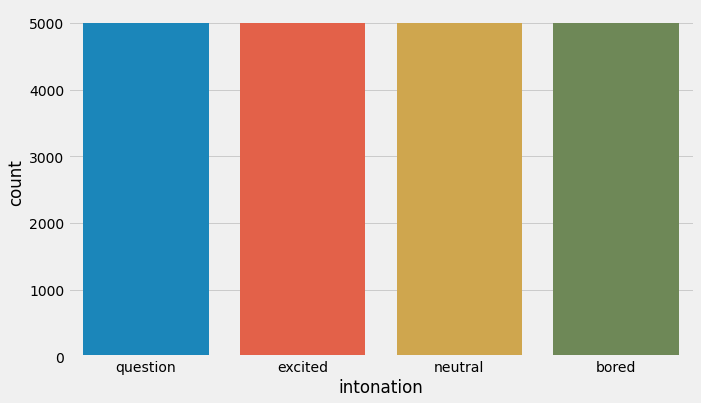

In [3]:
plt.figure(figsize=(10,6))
sns.countplot(x=INTONATION, data=dataset_df );

We have 5000 records of each category, so we can say that we have a balanced dataset.

In [4]:
intonation_categories = dataset_df.groupby(INTONATION).groups
for _category, id_list in intonation_categories.items():
    print(f'{_category} category has {len(id_list)} records')

bored category has 5000 records
excited category has 5000 records
neutral category has 5000 records
question category has 5000 records


This dataset is used to retrieve each audio to extract their features. We will end up with a different dataset afterwords, which contains the extracted features, and their intonation labels.

To prepare this new dataset, we need first to know what features to extract.

## Exploring Audio Data


Raw audios need to be processed by extracting relevant information so that you can use it in our classifier.

This section is relatively long, only to explain how are these chosen features related to our classification problem.

Most of the plots code snippets are inspired mostly from Librosa and some kaggle kernel notes, I will be mentioning thm at the end.


A fair notice, I am using samples which are mostly a perfect representation of the tone being voiced.

Now let's get comfortable with audio data, we can plot an audio in two domains:
#### 1. *Waveplot*
Representing audio signal in time domain using sample rate, showing the amplitude (loudness) of the audio at a given time.

Side note: LibRosa normalizes the amplitude that is why we will see the y-axis represents normalized amplitiude between -1 and 1.

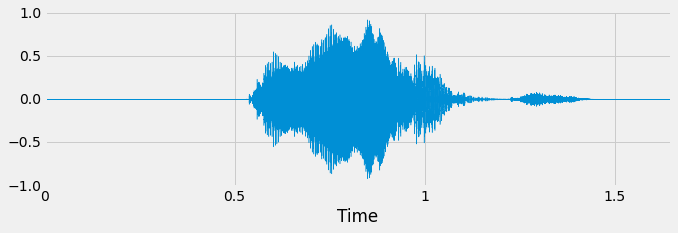

In [5]:
# load sample and plot the wave in time
file_path = f"{AUDIO_DIR}/{excited_df.iloc[120][FILE_ID]}"
x, sr = librosa.load(file_path)
plt.figure(figsize=(10, 3))
librosa.display.waveplot(x, sr=sr,);

The first thing I've noticed is the leading and trailing silence. So let's get rid of them.

Trimming will reduce further computation when we perform feature extraction, and we will end up with less irrelevant data.

I am using 25 db (20 db is rustling leaves and 30 db is whispering) as a threshold to cut-off where the silence begins and ends.

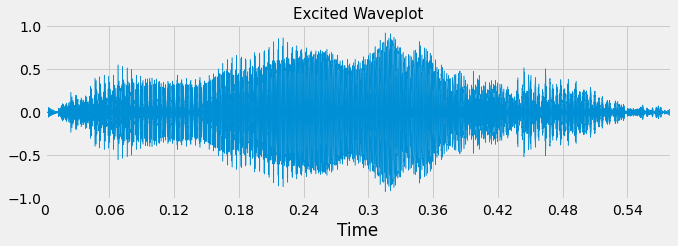

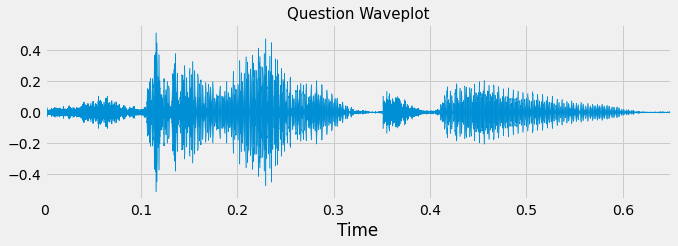

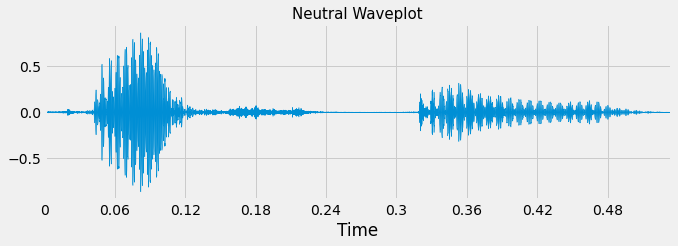

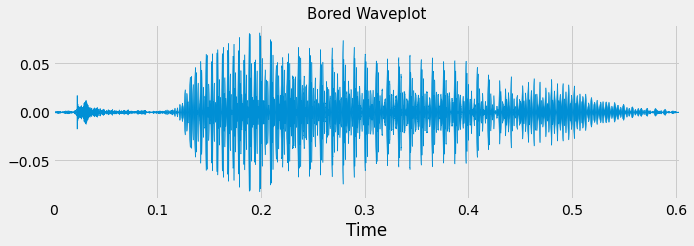

In [6]:
# trimming audio using LibRosa.
file_path = f"{AUDIO_DIR}/{excited_df.iloc[120][FILE_ID]}"
display(ipd.Audio(file_path))
x_excited, _ = librosa.effects.trim(x, top_db=25)
display_waveplot(x_excited, sr, 'Excited')

file_path = f"{AUDIO_DIR}/{question_df.iloc[120][FILE_ID]}"
display(ipd.Audio(file_path))
x_question, sr = load_trimmed_audio(file_path)
display_waveplot(x_question, sr, 'Question')

file_path = f"{AUDIO_DIR}/{neutral_df.iloc[120][FILE_ID]}"
display(ipd.Audio(file_path))
x_neutral, sr = load_trimmed_audio(file_path)
display_waveplot(x_neutral, sr, 'Neutral')

file_path = f"{AUDIO_DIR}/{bored_df.iloc[120][FILE_ID]}"
display(ipd.Audio(file_path))
x_bored,sr = load_trimmed_audio(file_path)
display_waveplot(x_bored, sr, 'Bored')


The signal extracted from the audios is definitely not sufficient to identify features and characteristics of each different intonation.

#### 2. *Spectrogram*

Moving to frequency domain, we represent an audio using spectrogram which displays changes in the frequencies in a signal over time.
Amplitude is then represented on a third dimension with variable brightness or color (the right-side vertical bar in dB is an amplitude indicator).


Let's plot the spectrogram for the same four audios and compare.

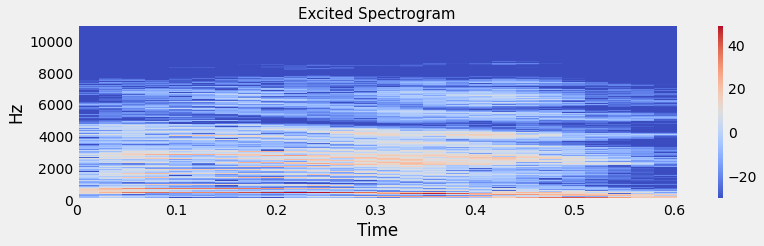

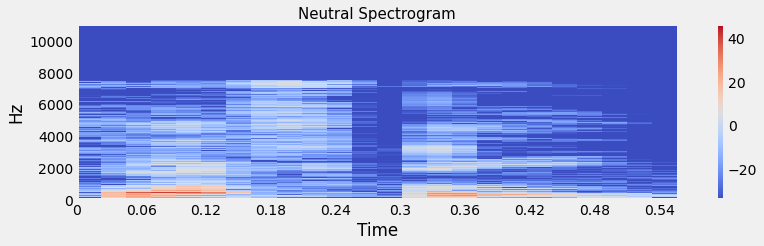

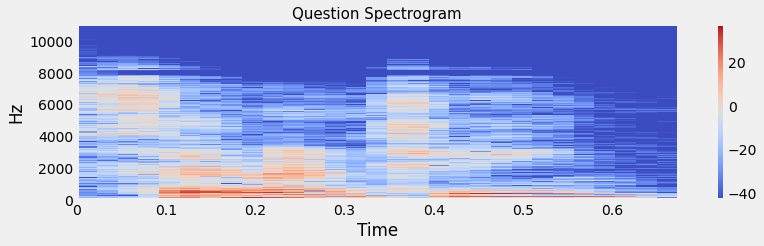

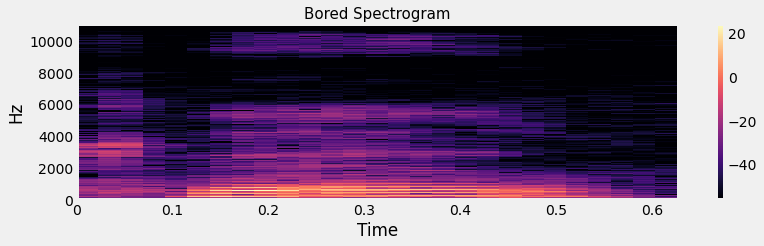

In [7]:
display_spectrogram(x_excited, sr, 'Excited')
display_spectrogram(x_neutral, sr, 'Neutral')
display_spectrogram(x_question, sr, 'Question')
display_spectrogram(x_bored, sr, 'Bored')

Excited and question samples are showing higher amplitudes, neutral is in between, whereas the bored audio has a distinguishable spectrogram among the rest, as it has the lowest amplitudes.


## Audio Features Extractions

In this section, I'm sharing the process of identifying good audio features that will help us in this ML problem.

#### *Fundamental Frequency*
The fundamental frequency **F0** is the frequency at which vocal cords vibrate in voiced sounds.

In [8]:
def display_pitch(X, sr, tone):
    winLen=0.02
    p = winLen * sr
    hop_length = 512
    frame_length = int(2 ** int(p - 1).bit_length())
    f0, voiced_flag, _ = librosa.pyin(y=X, fmin=80, fmax=450, sr=sr, frame_length=frame_length,
                                      hop_length=hop_length)
    times = librosa.times_like(f0)

    # get amplitudes of the audio
    D = librosa.amplitude_to_db(np.abs(librosa.stft(X)), ref=np.max)

    # plt.figure(figsize=(10, 3))
    fig, ax = plt.subplots()
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
    plt.title(f'fundamental frequency estimation for {tone} audio')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
    ax.legend(loc='upper right')
    plt.show()

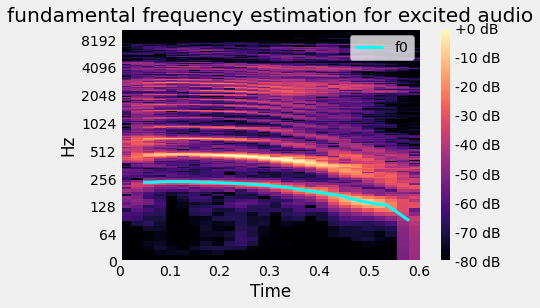

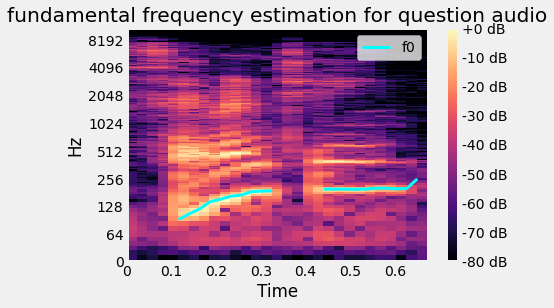

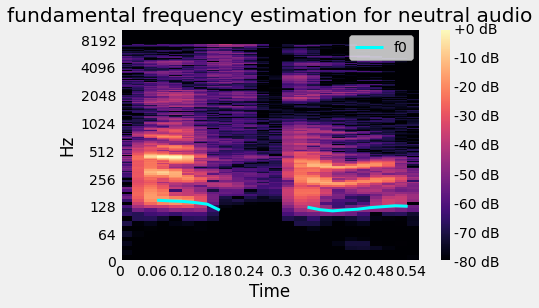

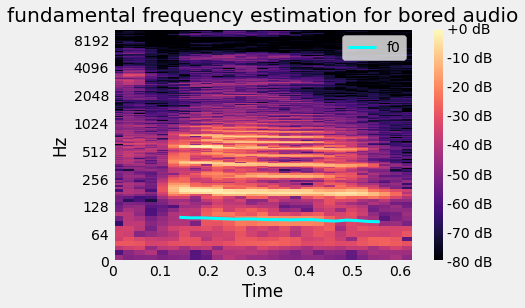

In [9]:
display_pitch(x_excited, sr, 'excited')
display_pitch(x_question, sr, 'question')
display_pitch(x_neutral, sr, 'neutral')
display_pitch(x_bored, sr, 'bored')

#### *MFCCs*
**Mel-frequency cepstral** coefficients concisely describe the overall shape of a spectral envelope, representing the characteristics of human voice, making them excellent information for speech-related tasks.


MFCC is computed using Mel filter-bank. These filters are typically narrower around 0Hz and wider for higher frequencies.

As you can see in the following plot.

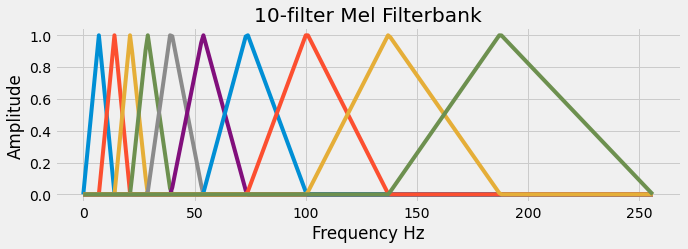

In [10]:
path = f"{AUDIO_DIR}/{dataset_df.iloc[745][FILE_ID]}"
x_, sr = load_trimmed_audio(path)
# get mfcc
mfcc_ = librosa.feature.mfcc(y=x_, sr=sr)
# get Mel filter-bank matrix, librosa normalizes the matrix
mel_basis = librosa.filters.mel(sr=sr, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2)
# transform the normalized matrix into equal height, dividing by the max of each row
mel_basis /= np.array(np.max(mel_basis, axis=1), ndmin=2).T

plt.figure(figsize=(10, 3))
plt.xlabel('Frequency Hz')
plt.ylabel('Amplitude')
plt.title('10-filter Mel Filterbank')
plt.plot(mel_basis.T)
plt.show()

This means that we have very good resolution in low frequencies, the opposite is true for higher frequencies.  So the most of the information is located in lower frequencies (i.e. formants). Therefore, in speech recognition we mostly use the 12-13 lower values.

Let's compare the **mean of 13 coefficients** for bored people enunciating the number *1*

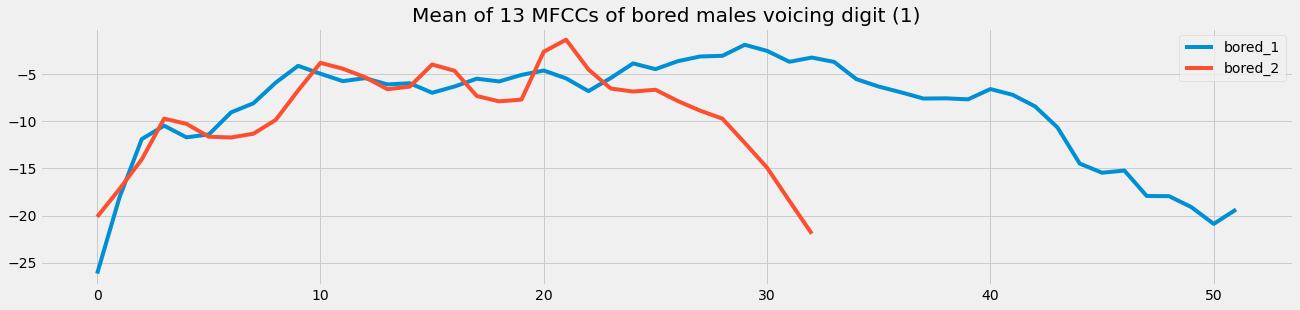

In [11]:
# load the first bored audio, extract 20 mfcc and compute there means
path = f"{AUDIO_DIR}/{dataset_df.iloc[745][FILE_ID]}"
x_bored_1, sr = load_trimmed_audio(path)
mfcc_bored_1 = np.mean(librosa.feature.mfcc(y=x_bored_1, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">bored_1</h6>'), ipd.Audio(path))

# load the second bored audio, extract 20 mfcc and compute there means
path = f"{AUDIO_DIR}/{dataset_df.iloc[19053][FILE_ID]}"
x_bored_2, sr = load_trimmed_audio(path)
mfcc_bored_2 = np.mean(librosa.feature.mfcc(y=x_bored_2, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">bored_2</h6>'), ipd.Audio(path))

# plot the 2 mfccs
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(mfcc_bored_1, label=f'{dataset_df.iloc[745][INTONATION]}_1')
plt.plot(mfcc_bored_2, label=f'{dataset_df.iloc[19053][INTONATION]}_2')
plt.title('Mean of 13 MFCCs of bored males voicing digit (1)')
plt.legend()
plt.show()

They are pretty close. **HOWEVER**, this is an ideal case, because I specifically choose two male audios who also have similar bored tones, but this is just to illustrate how it supposed to work *"in a perfect world"*  and visualize how MFCCs express two similar audios' characterstics (tones in our case). Although, we can also see that the first audio is longer, which is one of the reasons why our final accuracy is affected.

Now let's see a plot for four different tones voicing the digit *70*.

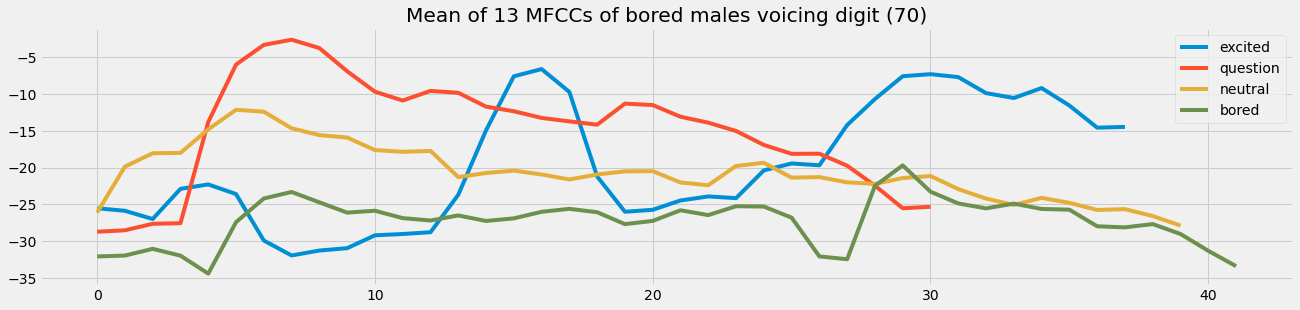

In [12]:
# Excited MFCC
path = f"{AUDIO_DIR}/{dataset_df.iloc[13293][FILE_ID]}"
X, sr = load_trimmed_audio(path)
excited_70 = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">Excited</h6>'), ipd.Audio(path))

# Question MFCC
path = f"{AUDIO_DIR}/{dataset_df.iloc[1258][FILE_ID]}"
X, sr = load_trimmed_audio(path)
question_70 = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">Question</h6>'), ipd.Audio(path))

# Neutral MFCC
path = f"{AUDIO_DIR}/{dataset_df.iloc[12221][FILE_ID]}"
X, sr = load_trimmed_audio(path)
neural_70 = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">Neutral</h6>'), ipd.Audio(path))

# Bored MFCC
path = f"{AUDIO_DIR}/{dataset_df.iloc[220][FILE_ID]}"
X, sr = load_trimmed_audio(path)
bored_70 = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">Bored</h6>'), ipd.Audio(path))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.subplot(3,1,1)
plt.plot(excited_70, label='excited')
plt.plot(question_70, label='question')
plt.plot(neural_70, label='neutral')
plt.plot(bored_70, label='bored')
plt.title('Mean of 13 MFCCs of bored males voicing digit (70)')
plt.legend()
plt.show()

For the same voiced word "**seventy**", the four different tones are distinguishable, since MFCC is a good feature to differentiate emotions/tones as demonstrated above.

excited and question tones tend to have a higher coefficients values, while neutral and bored coefficients are lower.

#### *Root Mean Square Energy*

The RMS Energy (RMSE) is simply the square root of the mean squared amplitude over a time window.

This feature is clearly differentiating between the tones, since are relating on the fact that bored and (most of) neutral audios have lower amplitude, whereas question and excited have higher amplitudes.

In [13]:
def display_rms_energy(X, sr, tone):
    frame_length=2048
    hop_length=512
    # compute sum of signal square by frame
    energy = np.array([
        sum(abs(X[i:i+frame_length]**2))
        for i in range(0, len(X), hop_length)
    ])
    # compute RMS
    rmse = librosa.feature.rms(X)
    # plot energy and rmse along the waveform
    frames = range(len(energy))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    plt.figure(figsize=(10, 2))
    plt.title(f'RMSE {tone}')
    librosa.display.waveplot(X, sr=sr, alpha=0.4)
    # normalized for visualization
    plt.plot(t, energy/energy.max(), 'r--')
    # normalized for visualization
    plt.plot(t[:len(rmse)], rmse/rmse.max(), color='blue')
    plt.legend(('Energy', 'RMSE'))
    plt.show()

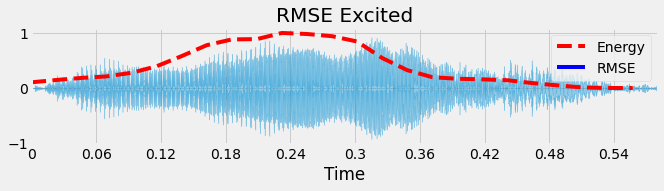

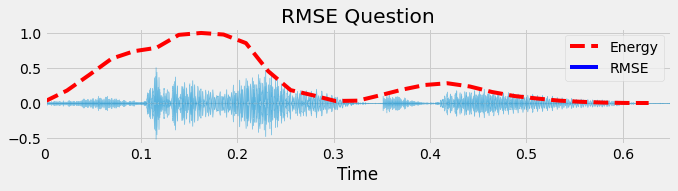

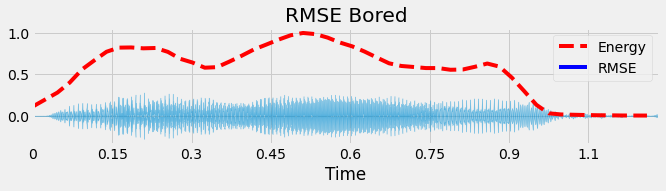

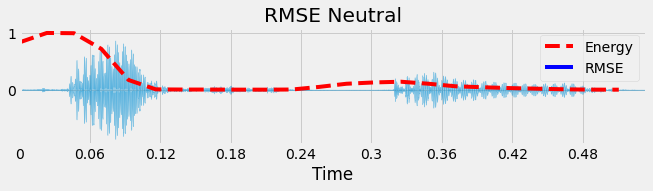

In [14]:
display_rms_energy(x_excited, sr, 'Excited')
display_rms_energy(x_question, sr, 'Question')
display_rms_energy(x_bored_1, sr, 'Bored')
display_rms_energy(x_neutral, sr, 'Neutral')

#### *Zero Crossing Rate*
The rate of sign-changes of the signal during the duration of a particular frame, making it a key feature to classify percussive sounds and the simplest method to distinguish between voiced and unvoiced speech.

However, this feature is highly dependant on the length of the audio.

In [15]:
total_zero_crossing_bored = np.sum(librosa.zero_crossings(y=x_bored))
total_zero_crossing_neutral = np.sum(librosa.zero_crossings(y=x_neutral))
total_zero_crossing_excited = np.sum(librosa.zero_crossings(y=x_excited))
total_zero_crossing_question = np.sum(librosa.zero_crossings(y=x_question))

print(f"Number of zero crossings in Bored audio is {total_zero_crossing_bored}")
print(f"Number of zero crossings in Neutral audio is {total_zero_crossing_neutral}")
print(f"Number of zero crossings in Excited audio is {total_zero_crossing_excited}")
print(f"Number of zero crossings in Question audio is {total_zero_crossing_question}")

Number of zero crossings in Bored audio is 563
Number of zero crossings in Neutral audio is 1618
Number of zero crossings in Excited audio is 679
Number of zero crossings in Question audio is 1715


In [16]:
def plot_spectral_features(spectral_feature, tone):
    # Computing the time variable for visualization
    frames = range(len(spectral_feature))
    # Converts frame counts to time (seconds)
    t = librosa.frames_to_time(frames)
    #Plotting the Spectral Centroid along the waveform
    plt.plot(t, sklearn.preprocessing.minmax_scale(spectral_feature), label=tone)

#### *Chroma Features*
A.K.A *chromagram*, is referred to as “<font color="green">**pitch class profile**</font>”, which is used to extract 12-element representation of spectral energy called **chroma vector**.

Pitch class profile are majorly used for analyzing music, in our case, we need it to analyze tones or emotions.

Notice how the profiles differ for each class in the following plots.


In [17]:
def display_chromagram(X, sr, tone):
    chromagram = librosa.feature.chroma_stft(X, sr=sr, hop_length=5000)
    plt.figure(figsize=(10, 3))
    plt.title(f'chromagram {tone}')
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=5000, cmap='coolwarm')
    plt.show()

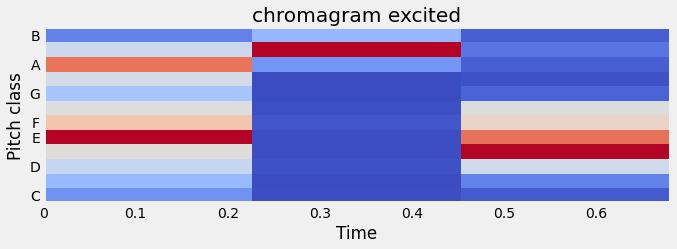

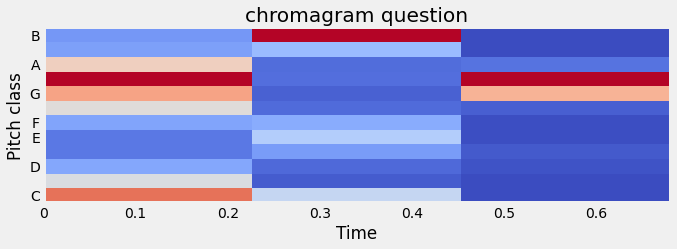

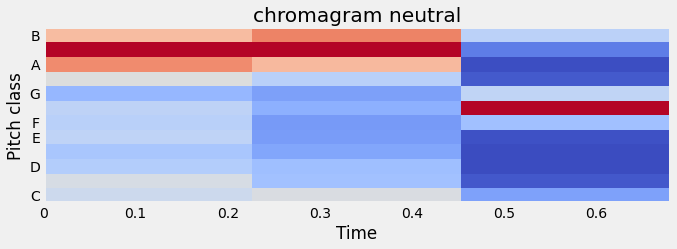

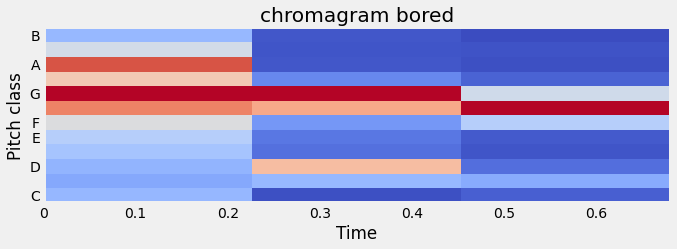

In [18]:
display_chromagram(x_excited, sr, 'excited')
display_chromagram(x_question, sr, 'question')
display_chromagram(x_neutral, sr, 'neutral')
display_chromagram(x_bored, sr, 'bored')


#### *Harmony and Percussion*
Harmonics are characteristics that human years can't distinguish (represents the sound color)
Percussion understanding shock wave represents the sound rhythm and emotion.

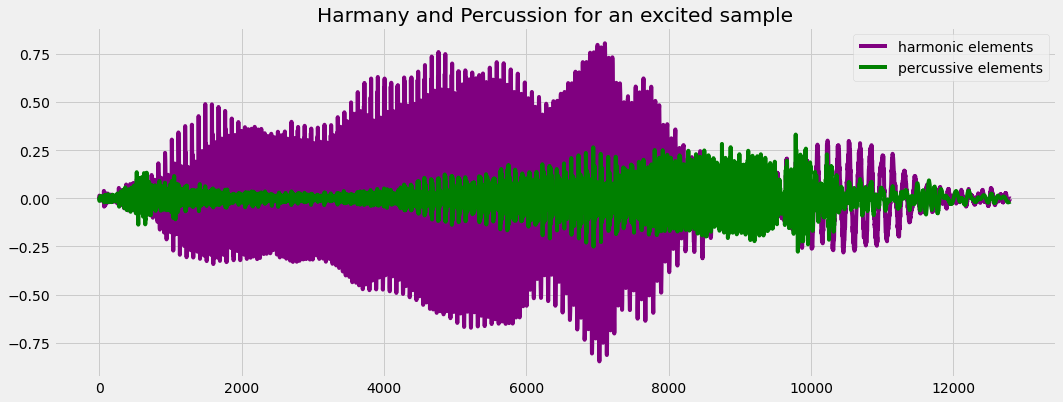

In [19]:
y_harm, y_perc = librosa.effects.hpss(x_excited)
plt.figure(figsize = (16, 6))
plt.title('Harmany and Percussion for an excited sample')
plt.plot(y_harm, color='purple', label='harmonic elements');
plt.plot(y_perc, color='green', label='percussive elements');
plt.legend()
plt.show()

#### *Spectral Rolloff*
The roll-off is the frequency below which 85% of accumulated spectral magnitude is concentrated.

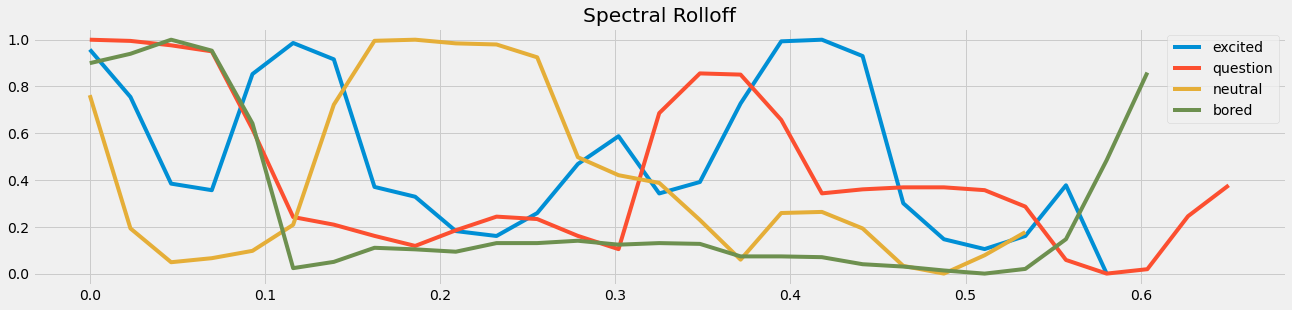

In [20]:
# get the rolloff vector
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
spectral_rolloff = librosa.feature.spectral_rolloff(x_excited, sr=sr)[0]
plot_spectral_features(spectral_rolloff, 'excited')
spectral_rolloff = librosa.feature.spectral_rolloff(x_question, sr=sr)[0]
plot_spectral_features(spectral_rolloff, 'question')
spectral_rolloff = librosa.feature.spectral_rolloff(x_neutral, sr=sr)[0]
plot_spectral_features(spectral_rolloff, 'neutral')
spectral_rolloff = librosa.feature.spectral_rolloff(x_bored, sr=sr)[0]
plot_spectral_features(spectral_rolloff, 'bored')
plt.title(f'Spectral Rolloff')
plt.legend()
plt.show()

I also tried other spectral features (centroid, flatness, contrast and bandwidth). But I dropped them to reduce dimensionality, the following features combination were chosen since they gave the best accuracy.


## Dataset Preparation

Now that we settled on which features to extract, we need to think if the audios need preprocessing before the extraction.

I have already mentioned the trimming part, since it will save us lots of time and calculation, not to mention reducing irrelevant data.

I also tried pre-emphsising the audio, and scaling up the signal as a preprocessing techniques (each experiment done separately), but the accurcy didn't come out as good, so I will be only trimming the data.

Here are the script to extract the <font color=green>**mean & standard deviation**</font> of each mentioned feature using LibRosa for the 20K preprocessed (trimmed) audios.

The features are saved along with their corresponding labels in a csv file.
The following cell shows how I did it.

In [21]:
def extract_features(data, sample_rate, winLen=0.02):
    """
    Extracted the listed audio features below from an audio signal

    :param data: audio signal
    :param sample_rate: sampling rate at which the data signal was sampled at
    :param winLen: desired window length to calculate fundamental frequency
    :return: tuple of list of teh names of features (header) and the extracted features array
    """
    result = np.array([])
    headers = []

    # Fundamental Frequency
    p = winLen * sample_rate
    frame_length = int(2 ** int(p - 1).bit_length())
    hop_length = frame_length // 2
    f0, voiced_probs, _ = librosa.pyin(y=data, fmin=80, fmax=450, sr=sample_rate, frame_length=frame_length, hop_length=hop_length)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0)) < 1 else 0
    pitch_std = np.nanstd(f0) if np.mean(np.isnan(f0)) < 1 else 0
    headers.extend(['pitch_mean', 'pitch_std'])
    result = np.hstack((result, pitch_mean, pitch_std))

    # Root Mean Square Value
    rms = librosa.feature.rms(y=data)
    headers.extend(['RMS_energy_mean', 'RMS_energy_std'])
    result = np.hstack((result, np.mean(rms), np.std(rms)))

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(y=data)
    headers.extend(['zero_crossing_rate_mean', 'zero_crossing_rate_std'])
    result = np.hstack((result, np.mean(zcr), np.std(zcr)))

    # Chroma
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate)[0]
    headers.extend(['chroma_mean', 'chroma_std'])
    result = np.hstack((result, np.mean(chroma_stft), np.std(chroma_stft)))

   # Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)[0]
    headers.extend([f'rolloff_mean', 'rolloff_std'])
    result = np.hstack((result, np.mean(rolloff), np.std(rolloff)))

    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    for _i in range(1, len(mfcc) + 1):
        headers.extend([f'mfcc_mean_{_i}', f'mfcc_std_{_i}'])
        result = np.hstack((result, np.mean(mfcc), np.std(mfcc)))

    # Harmony and Percussion
    y_harm, y_perc = librosa.effects.hpss(data)
    headers.extend(['harm_mean', 'harm_std', 'perc_mean', 'perc_std'])
    result = np.hstack((result, np.mean(y_harm), np.std(y_harm), np.mean(y_perc), np.std(y_perc)))
    return headers, result

def preprocess_date(files_list, ml_end_df, trim=False, emphasise=False, scale_audio=False, sampling_rate=None):
    """
    Extract features for the passed audio files with the required preprocessing method

    :param files_list: list of paths of audio files
    :param ml_end_df: MLEnd dataset (pandas dataframe)
    :param trim: True if we want to trim the audios first
    :param emphasise: True if we want to emphasise the audios first
    :param scale_audio: True if we want to scale up the audios first
    :param sampling_rate: if not used 22050 Hz will be used as default
    :return: tuple of headers array that will be used for csv file, features array and labels array
    """
    features, labels = [], []
    for file in tqdm(files_list):
        file_id = file.split('/')[-1]
        y_intonation = ml_end_df.loc[ml_end_df[FILE_ID] == file_id][INTONATION].iloc[0]
        # extract the intonation label from the dataset and encode it to a corresponding number [0, 1, 2, 3]
        yi = INTONATION_LABELS[y_intonation]
        data, sampling_rate = librosa.load(file, sr=sampling_rate)
        # preprocess, trim audio leading and trailing silence at 25db
        if trim:
            data, index = librosa.effects.trim(data)
        # preprocess, emphasise audio
        if emphasise:
            data = librosa.effects.preemphasis(data)
        # preprocess, scale up the audio
        if scale_audio:
            data = data / np.max(np.abs(data))
        headers, xi = extract_features(data=data, sample_rate=sampling_rate)
        features.append(xi)
        labels.append(yi)
    headers.insert(0, 'label')
    return headers, np.array(features), np.array(labels)

def extract_and_save_features(dir_path, files_list, ml_end_df,  trim, emphasise, scale_audio):
    """
    This is the main function to extract feature from audio fiule and save features in csv and npy file.

    :param dir_path: path to directory were files are saved
    :param files_list: list of audios files paths
    :param ml_end_df: MLEnd dataframe
    :param trim: True if we want to trim the audios first
    :param emphasise: True if we want to emphasise the audios first
    :param scale_audio: True if we want to scale up the audios first
    :return: None
    """

    headers, x, y = preprocess_date(files_list, ml_end_df, trim=trim,
                                 emphasise=emphasise, scale_audio=scale_audio)

    # stack labels then the features
    save_array = np.column_stack([y, x])
    file_name = f'extracted_features'
    if trim:
        file_path = f'{dir_path}/{file_name}_after_trim'
    elif emphasise:
        file_path = f'{dir_path}/{file_name}_after_emphasise'
    elif scale_audio:
        file_path = f'{dir_path}/{file_name}_after_scale'
    else:
        file_path = f'{dir_path}/{file_name}'
    # save as a npy and csv
    np.save(f'{file_path}.npy', save_array)
    np.savetxt(f'{file_path}.csv', save_array, delimiter=',', header=','.join(headers))
    return None

After preparing the features, the fun part starts, let's load the extracted features csv file and inspect it closely.

In [22]:
features_csv = f'{Features_dir}/extracted_features_after_trim.csv'
# I saved mfcc means and std in a separate file for testing purposes.
mfcc_features_csv = f'{Features_dir}/all_data_mfcc_features.csv'

main_data = pd.read_csv(features_csv)
mfcc_data = pd.read_csv(mfcc_features_csv)

# combining both df
all_features_df = pd.concat([
    main_data.drop(columns=['harm_mean', 'harm_std'], axis=1),
    # dropping the label column in mfcc df since it is duplicated in main features df
    mfcc_data.drop(columns=[LABEL_COLUMN], axis=1).iloc[:, 10:26],
 ], axis=1)

# separating features and labels in different dfs
predictors = all_features_df.iloc[:, 1:]
labels = all_features_df.iloc[:, 0].astype(int)
# y_labels.replace({0: 1,1:0, 2: 0, 3:0}, inplace=True)

print(f"Number of extracted features {predictors.shape[1]}\n")
print(f"The features are: {predictors.columns}\n")
print(f"Number of NaN value is: {predictors.isna().sum()[0]}\n")

predictors.describe()

Number of extracted features 28

The features are: Index(['pitch_mean', 'pitch_std', 'RMS_energy_mean', 'RMS_energy_std',
       'zero_crossing_rate_mean', 'zero_crossing_rate_std', 'chroma_mean',
       'chroma_std', 'rolloff_mean', 'rolloff_std', 'perc_mean', 'perc_std',
       'mfcc_mean_6', 'mfcc_std_6', 'mfcc_mean_7', 'mfcc_std_7', 'mfcc_mean_8',
       'mfcc_std_8', 'mfcc_mean_9', 'mfcc_std_9', 'mfcc_mean_10',
       'mfcc_std_10', 'mfcc_mean_11', 'mfcc_std_11', 'mfcc_mean_12',
       'mfcc_std_12', 'mfcc_mean_13', 'mfcc_std_13'],
      dtype='object')

Number of NaN value is: 0



,pitch_mean,pitch_std,RMS_energy_mean,RMS_energy_std,zero_crossing_rate_mean,zero_crossing_rate_std,chroma_mean,chroma_std,rolloff_mean,rolloff_std,...,mfcc_mean_9,mfcc_std_9,mfcc_mean_10,mfcc_std_10,mfcc_mean_11,mfcc_std_11,mfcc_mean_12,mfcc_std_12,mfcc_mean_13,mfcc_std_13
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,181.039943,32.583639,0.033351,0.041051,0.121987,0.086493,0.646455,0.240497,4493.305033,1984.413145,...,-20.022924,109.280403,-20.022924,109.280403,-20.022924,109.280403,-20.022924,109.280403,-20.022924,109.280403
std,74.797754,29.236781,0.032505,0.037282,0.068104,0.052732,0.111454,0.053958,1323.841055,591.650238,...,6.466885,20.444151,6.466885,20.444151,6.466885,20.444151,6.466885,20.444151,6.466885,20.444151
min,0.000000,0.000000,0.000159,0.000219,0.002384,0.001044,0.158668,0.014003,242.565200,101.417094,...,-39.557343,48.059616,-39.557343,48.059616,-39.557343,48.059616,-39.557343,48.059616,-39.557343,48.059616
25%,121.682111,8.246905,0.011466,0.014722,0.071591,0.045397,0.572631,0.201904,3603.155501,1564.106208,...,-24.660003,94.349680,-24.660003,94.349680,-24.660003,94.349680,-24.660003,94.349680,-24.660003,94.349680
50%,171.919954,23.143335,0.023189,0.029455,0.108874,0.076781,0.655483,0.240129,4454.961174,1986.888177,...,-19.908974,107.992886,-19.908974,107.992886,-19.908974,107.992886,-19.908974,107.992886,-19.908974,107.992886
75%,226.307401,50.582899,0.043405,0.054753,0.158916,0.119165,0.727506,0.278634,5362.821808,2399.682914,...,-15.219649,123.024529,-15.219649,123.024529,-15.219649,123.024529,-15.219649,123.024529,-15.219649,123.024529
max,449.941853,165.301582,0.299464,0.322401,0.581003,0.320862,0.996173,0.433087,9196.635298,4041.423332,...,-1.273803,181.555298,-1.273803,181.555298,-1.273803,181.555298,-1.273803,181.555298,-1.273803,181.555298


Correlation matrix...


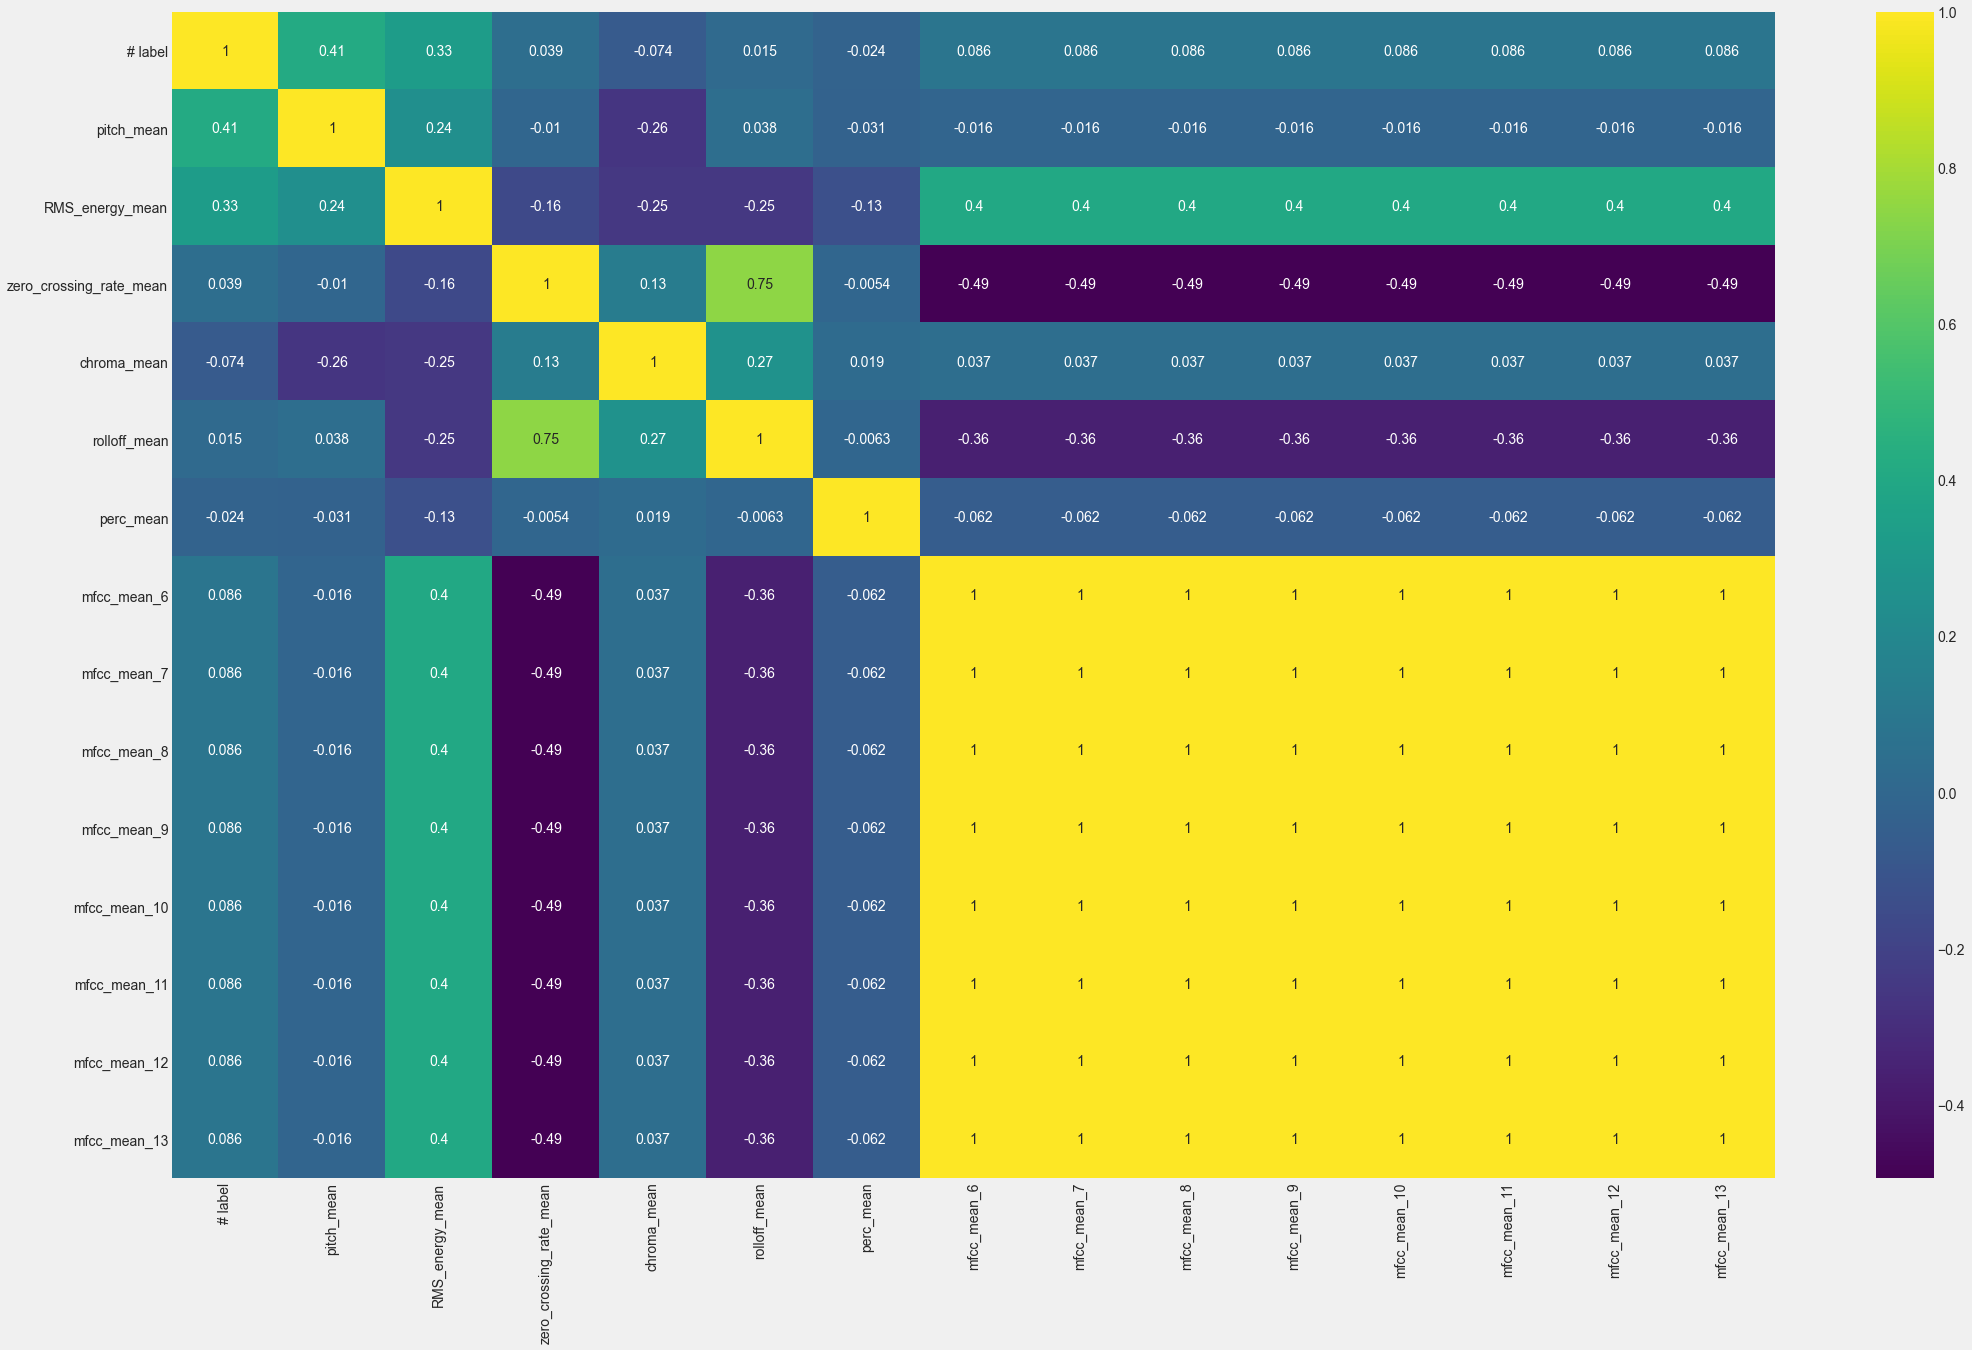

In [23]:
# Computing the Correlation Matrix
print ("Correlation matrix...")
spike_cols = [col for col in all_features_df.columns if 'mean' in col or 'label' in col]
corr_data = all_features_df[spike_cols].corr()
plt.figure(figsize=(32, 20))
sns.set_style('ticks')
sns.heatmap(corr_data, cmap='viridis',annot=True)
plt.show()

Notice how the mfcc features are correlated, that is why I only used coefficients 6 to 13.


## Preprocessing.

There are two major scaling method:
- Normalization
- Standardization

Since I am using SVM with kernel `RBF` kernel, it is essential to standardize the data, because the algorithm assumes that all features are centered around 0 and have variance in the same order.

I am using Principal component Analysis (PCA) to reduce dimensionality to 2, so we can plot the predictor space.

In [24]:
# Standardize features by removing the mean and scaling to unit variance
standard_scaler = preprocessing.StandardScaler()
scaled_x = standard_scaler.fit_transform(predictors)

# Use PCA 2 components to visualize all the data
pca = PCA(n_components=2)
pca_x = pca.fit_transform(scaled_x)
pcaX_df = pd.DataFrame(data = pca_x, columns = ['x1', 'x2'])

print(f"Total features utilization in the resulted two PCA components : {np.sum(pca.explained_variance_ratio_)}")

Total features utilization in the resulted two PCA components : 0.6717465152246018


In [25]:
def plot_predictor_space(x1: pd.DataFrame, x2: pd.DataFrame, y: pd.DataFrame, title: str):
    np_x1 = x1.to_numpy()
    np_x2 = x2.to_numpy()
    plt.figure(figsize=(6, 6))
    plt.scatter(np_x1[y==0], np_x2[y==0], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'Bored'))
    plt.scatter(np_x1[y==1], np_x2[y==1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'Neutral'))
    plt.scatter(np_x1[y==2], np_x2[y==2], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'Question'))
    plt.scatter(np_x1[y==3], np_x2[y==3], s=50 , color= '#0CC0FF', label='{:d} ({:s})'.format(3, 'Excited'))
    plt.title(title)
    plt.legend(fontsize=12)
    plt.xlabel(x1.columns[0], fontsize=14)
    plt.ylabel(x2.columns[0], fontsize=14)
    plt.xlim(np.min(np_x1)-0.1,np.max(np_x1)+0.1)
    plt.ylim(np.min(np_x2)-0.1,np.max(np_x2)+0.1)
    plt.grid(True)
    plt.show()

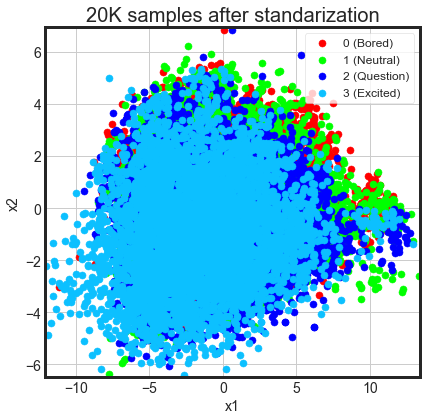

In [26]:
plot_predictor_space(pcaX_df[['x1']], pcaX_df[['x2']], labels, '20K samples after standarization')

Wow! that's a lot! Let's plot a 500 random sample for better visualization

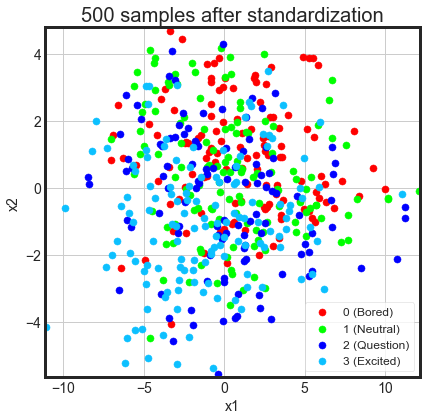

In [27]:
scaled_data = pd.concat([pcaX_df, labels], axis = 1)
random_sample_data = scaled_data.sample(n=500, replace=False)
plot_predictor_space(random_sample_data[['x1']], random_sample_data[['x2']], random_sample_data[[LABEL_COLUMN]],
                     '500 samples after standardization')

PCA represented the 28 predictors in two predictor `x1` and `x2`, and data seems unseperable linearly.

## Model(s) description

I am using SVM as a classifier, which is implemented in sklearn library, the model will try to find hyperplane that maximizes the margin between classes.

When data points that are not linearly separable, they are transformed using kernel functions so that they become linearly separable.

Kernelized SVM compute decision boundaries without actually doing a transformation.
I chose the kernel type <font color=green>rbf</font>, it will be used in the algorithm, it has two other hyperparameters:
 - C: Regularization parameter, add a penalty for each misclassified data point, when we increase C, a higher penelty applied, so the model will try to avoid misclassification, which results in a decision boundary with a smaller margi.
 - Gamma: Kernel coefficient, controls the distance of influence of a single training point. Using low values will result in more points being grouped together

In [28]:
# model initialization
model  = svm.SVC(C=1, gamma=0.5)
print(f"Initializing SVM, C={model.C}, Gamma={model.gamma}")

Initializing SVM, C=1, Gamma=0.5


## Training and validation

We can use the whole dataset, or a subset of it. I used the whole set as it performed the best, which is expected, more samples, better prediction.

The dataset (predictors and labels) is split into two sets, one for testing and the other for validation.

I used 14K for training and 6K for validation.

In [29]:
train_size = 0.7
# split dataset 70% Training 30% Validation
X_train, X_val, y_train, y_val = train_test_split(predictors,labels ,shuffle=True,train_size=train_size)

X_train.head()

,pitch_mean,pitch_std,RMS_energy_mean,RMS_energy_std,zero_crossing_rate_mean,zero_crossing_rate_std,chroma_mean,chroma_std,rolloff_mean,rolloff_std,...,mfcc_mean_9,mfcc_std_9,mfcc_mean_10,mfcc_std_10,mfcc_mean_11,mfcc_std_11,mfcc_mean_12,mfcc_std_12,mfcc_mean_13,mfcc_std_13
1901,98.311260,6.505457,0.042075,0.054150,0.035668,0.010431,0.640837,0.231996,1880.822754,1212.646051,...,-8.984469,98.623482,-8.984469,98.623482,-8.984469,98.623482,-8.984469,98.623482,-8.984469,98.623482
9000,132.314077,16.750952,0.004474,0.004968,0.176605,0.095714,0.728468,0.291017,6840.005903,1745.468612,...,-17.233873,102.970345,-17.233873,102.970345,-17.233873,102.970345,-17.233873,102.970345,-17.233873,102.970345
10943,164.220255,59.267589,0.034426,0.049767,0.040170,0.040669,0.698172,0.205269,3617.274840,1718.572205,...,-14.048014,108.903114,-14.048014,108.903114,-14.048014,108.903114,-14.048014,108.903114,-14.048014,108.903114
1519,174.333120,6.064151,0.012779,0.020024,0.062841,0.028148,0.804040,0.139071,4303.187187,2145.875210,...,-21.090794,134.573166,-21.090794,134.573166,-21.090794,134.573166,-21.090794,134.573166,-21.090794,134.573166
15620,204.211929,45.234222,0.152303,0.130799,0.068255,0.039000,0.589079,0.226180,2967.480469,1107.719720,...,-18.108318,72.762833,-18.108318,72.762833,-18.108318,72.762833,-18.108318,72.762833,-18.108318,72.762833


After splitting we perform standardization, on each set separately. This is because the validation set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

In [30]:
# Use standardization to scale data
standard_scaler = preprocessing.StandardScaler()
# Scale train data and validation data separately
# so the test doesn't become biased
scaledX_train = standard_scaler.fit_transform(X_train)
scaledX_val = standard_scaler.fit_transform(X_val)

### SVM training and validation:

In [31]:
model.fit(scaledX_train,y_train)
yv_pred_svm = model.predict(scaledX_val)

# calculate the percentage of correctly predicted labels
accuracy_v = np.mean(yv_pred_svm==y_val)

print(f'Model: SVM')
print('Validation  Accuracy', accuracy_v)

Model: SVM
Validation  Accuracy 0.6736666666666666


### Comparing Other models:

In [32]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
random_forest.fit(scaledX_train,y_train)
yv_pred = random_forest.predict(scaledX_val)
accuracy_v = np.mean(yv_pred==y_val)

print(f'Model: Random forest')
print('Validation  Accuracy', accuracy_v)

# Naive Bayes
nb = GaussianNB()
nb.fit(scaledX_train,y_train)
yv_pred = nb.predict(scaledX_val)
accuracy_v = np.mean(yv_pred==y_val)

print(f'Model: Naive Bayes')
print('Validation  Accuracy', accuracy_v)

# KNN
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(scaledX_train,y_train)
yv_pred = nb.predict(scaledX_val)
accuracy_v = np.mean(yv_pred==y_val)

print(f'Model K Nearest Neighbour')
print('Validation  Accuracy', accuracy_v)

Model: Random forest
Validation  Accuracy 0.638
Model: Naive Bayes
Validation  Accuracy 0.4355
Model K Nearest Neighbour
Validation  Accuracy 0.4355


## Performance evaluation
We evaluate the model using the validation accuracy. The SVM model was able to predict approximately 69% out of the 6000 samples.

The following graph show the confusion matrix, which is summarized in the printed report afterwords.


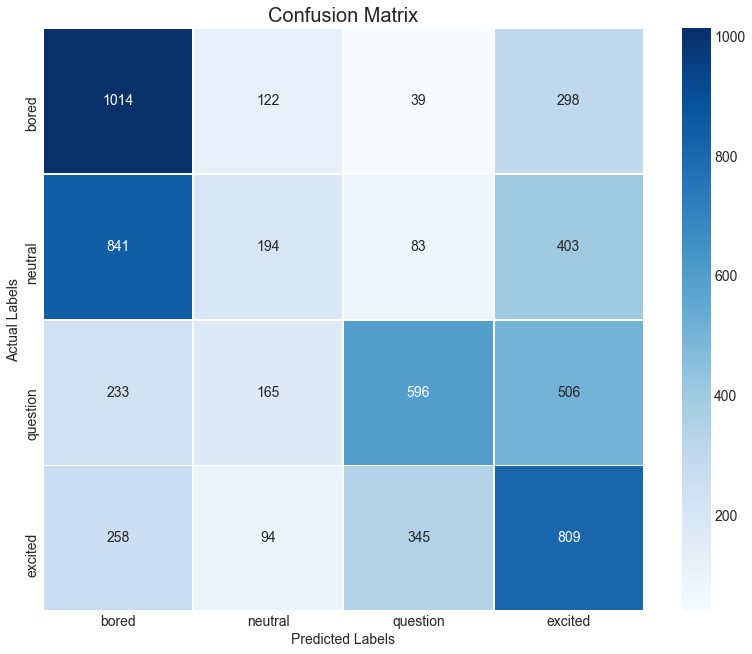

              precision    recall  f1-score   support

       bored       0.69      0.73      0.71      1473
     neutral       0.63      0.59      0.61      1521
    question       0.71      0.69      0.70      1500
     excited       0.66      0.70      0.68      1506

    accuracy                           0.67      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.67      0.67      0.67      6000



In [33]:
cm = confusion_matrix(y_val, yv_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in INTONATION_LABELS] , columns = [i for i in INTONATION_LABELS])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print(classification_report(y_val, yv_pred_svm, target_names=INTONATION_LABELS))


## Conclusions
We can see our model is more accurate in predicting bored, question intonation, perhaps because their audios were better presented. Or maybe we have more outliers presented in the other categories.

After all, the evaluation is affected by the audios quality. I inspected some of the audios closely, some are longer than others, some audios have very low voices, and a few are almost silent.

Overall accuracy is 69% on the validation data and its decent, but we can improve it more by applying augmentation techniques and using other feature extraction methods.


This notebook is hosted on github:
https://github.com/mu-hadeel/ML_PROJECT

Kaggle kernels that helped me in this project:
https://www.kaggle.com/kashnitsky/topic-2-visual-data-analysis-in-python
https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend